# Data Preparation

In [44]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px
from meteostat import Point, Daily, Hourly
import pytz

In [45]:
# # Download Fligt Delay Dataset form Kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files(
#     "robikscube/flight-delay-dataset-20182022",
#     path=DATA_DIR,
#     unzip=True,
# )

# for filename in os.listdir(DATA_DIR):
#     f = os.path.join(DATA_DIR, filename)
#     if f.endswith(".parquet") or filename == "Airlines.csv":
#         pass
#     else:
#         if os.path.isfile(f):
#             os.remove(f)
#         else:
#             shutil.rmtree(f)

## Download Location of airports
# urlretrieve(
#     "https://raw.githubusercontent.com/lxndrblz/Airports/main/airports.csv", 
#     DATA_DIR + "airports.csv"
#     )

In [235]:
#main_df = extract.combine_parquet(data_path = "data/")

airport_df = pd.read_csv('data/airports.csv')
airline_df = pd.read_csv('data/Airlines.csv')

#not optimal
from pyarrow.parquet import ParquetFile
import pyarrow as pa 

n = 1000000
pf = ParquetFile('data/Combined_flights_2020.parquet') 
first_ten_rows = next(pf.iter_batches(batch_size = n)) 
main_df = pa.Table.from_batches([first_ten_rows]).to_pandas()

In [236]:
def prep_data(df, departure_airport='DEN'):
    
    col_list =['FlightDate','Origin','DepDelayMinutes']
    
    #select columns
    df = df[df['Origin'] == 'DEN']
    df = df[small_col_list]
    df['FlightCount'] = 1

    df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    start_date = df['FlightDate'].min()
    end_date = df['FlightDate'].max()

    #set cancelled flights to zero delay min
    df['DepDelayMinutes'] =  df['DepDelayMinutes'].fillna(0)

    #group data
    df = df.groupby('FlightDate').agg({'DepDelayMinutes': 'mean', 'FlightCount': 'sum'})

    #add row for 
    idx = pd.date_range(start_date, end_date, freq='D')
    df = df.reindex(idx, fill_value=0)

    #add weather data
    weather_data = Daily(Point(39.855229533349956, -104.67398600087793), start_date, end_date).fetch()
    weather_data = weather_data.drop(['snow', 'wpgt', 'tsun'], axis=1)
    df = df.merge(weather_data, left_index=True, right_index=True)

    #time derived features
    df['day_of_week'] = [i.weekday() for i in df.index]
    df['hour_of_day'] = [i.hour for i in df.index]
    df['is_weekend'] =  [1 if ((i == 5) | (i == 6)) else 0 for i in df['day_of_week']]
    
    return df

In [237]:
df = prep_data(main_df)

In [239]:
#df.to_csv('data/input_data.csv')

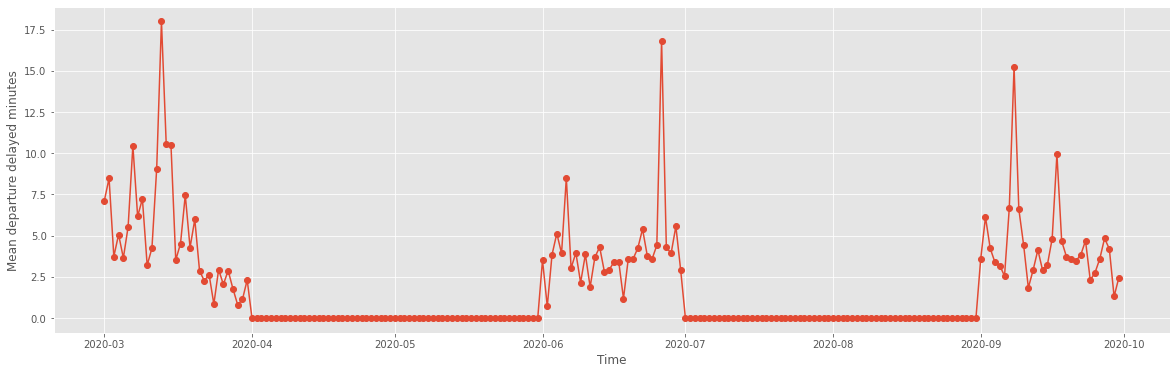

In [240]:
# plot timeseries for departur delay minutes
fig, ax = plt.subplots( figsize=(20,6))
plt.plot(df[['DepDelayMinutes']], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Mean departure delayed minutes');